In [135]:
import pandas as pd
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score


def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    if classifier == LogisticRegression:
        model = classifier(max_iter=25)
    else:
        model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), \
        precision_score(y_test, y_predict , average='weighted'), \
        recall_score(y_test, y_predict, average='weighted')

In [ ]:
raw_audio = dict()
'''
directory = 'hungry'
for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        raw_audio[os.path.join(directory, filename)] = 'hungry'
    else:
        continue
'''
directory = 'burping'
for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        raw_audio[os.path.join(directory, filename)] = 'burping'
    else:
        continue

directory = 'belly_pain'
for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        raw_audio[os.path.join(directory, filename)] = 'belly_pain'
    else:
        continue

directory = 'discomfort'
for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        raw_audio[os.path.join(directory, filename)] = 'discomfort'
    else:
        continue

directory = 'tired'
for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        raw_audio[os.path.join(directory, filename)] = 'tired'
    else:
        continue

In [ ]:
from pydub import AudioSegment
def chop_song(filename,pasta,caminho):
    # Abre o arquivo de áudio original
    audio = AudioSegment.from_wav(caminho)
    # Define o tempo inicial e final para extrair o trecho de 1,5 segundos
    inicio = 0  # tempo inicial em milissegundos
    fim = 5000  # tempo final em milissegundos
    trecho = audio[inicio:fim]
    # Grava um novo arquivo com apenas 5 segundo do áudio original
    trecho.export(pasta+'bak'+'/'+filename, format="wav")

for audio_file in raw_audio:
    print(audio_file)
    pasta = audio_file.split("\\")[0]
    nome = audio_file.split("\\")[1]
    chop_song(nome,pasta,audio_file)

In [85]:
listaModeloPrecisao = {}

In [86]:
testes = 100 #Features

In [ ]:
for features in range(1,testes+1):
    numeroDeFeatures = features
    try:
        X = pd.DataFrame(columns=np.arange(numeroDeFeatures+1), dtype='float32').astype(np.float32)
        j = 0
        k = 0
        u = 0
        p = 0
        for i, filename in enumerate(os.listdir('Crying')):
            last_number_frames = -1
            if filename.endswith(".wav"):
                audiofile, sr = librosa.load('Crying/' + filename)
                fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=numeroDeFeatures)
                x = pd.DataFrame(fingerprint, dtype='float32')
                x[numeroDeFeatures] = 'Crying'
                X.loc[i] = x.loc[0]
                j = i
        for i, filename in enumerate(os.listdir('laugh')):
            if filename.endswith(".wav"):
                #print filename
                audiofile, sr = librosa.load('laugh/' + filename)
                fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=numeroDeFeatures)
                x = pd.DataFrame(fingerprint, dtype='float32')
                x[numeroDeFeatures] = 'laugh'
                X.loc[i + j] = x.loc[0]
                k = i

        for i, filename in enumerate(os.listdir('Noise')):
            if filename.endswith(".ogg"):
                print(i,filename)
                audiofile, sr = librosa.load('Noise/' + filename)
                fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=numeroDeFeatures)
                x = pd.DataFrame(fingerprint, dtype='float32')
                x[numeroDeFeatures] = 'Noise'
                X.loc[i + j + k] = x.loc[0]
                u = i

        for i, filename in enumerate(os.listdir('silence')):
            if filename.endswith(".wav"):
                #print filename
                audiofile, sr = librosa.load('silence/' + filename)
                fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=numeroDeFeatures)
                x = pd.DataFrame(fingerprint, dtype='float32')
                x[numeroDeFeatures] = 'silence'
                X.loc[i + j + k + u] = x.loc[0]
        X = X.fillna(0)


        y = X[numeroDeFeatures]
        del X[numeroDeFeatures]
        X = X.astype(np.float32)
        X_train, X_test, y_train, y_test = train_test_split(X, y)

        listaModeloPrecisao[features-1] = (
            get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test, n_estimators=100,max_features=numeroDeFeatures),
            get_scores(DecisionTreeClassifier, X_train, X_test, y_train, y_test),
            get_scores(SVC, X_train, X_test, y_train, y_test)
        )
    except Exception as e:
        print(e)
        pass


In [88]:
precisao = pd.DataFrame(columns=np.arange(5), dtype=object)
precisao = precisao.rename(columns={0:'Accuracy', 1:'Precision', 2:'Recall',3:'features',4:'modelo'})

In [89]:
def modelos(s):
    if s == 0 :
        return 'RandomForestClassifier'
    elif s == 1:
        return 'DecisionTreeClassifier'
    elif s == 2:
        return 'SVC'

In [90]:
for feature in listaModeloPrecisao:
    for modelo in range(3):
        precisao.loc[len(precisao)] = listaModeloPrecisao[feature][modelo]+(feature+1,modelos(modelo))

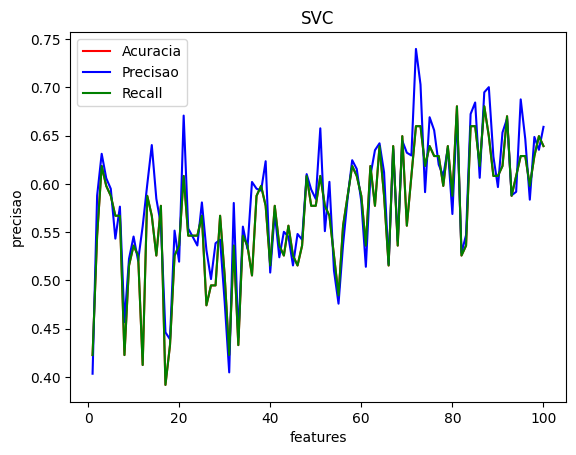

In [91]:
SVC = precisao[precisao.modelo == 'SVC'].sort_values(by='features')
plt.plot(SVC.features,SVC.Accuracy, label='Acuracia',color='red')
plt.plot(SVC.features,SVC.Precision, label='Precisao',color = 'blue')
plt.plot(SVC.features,SVC.Accuracy, label='Recall',color='green')
plt.xlabel('features')
plt.ylabel('precisao')
plt.title('SVC')
plt.legend()
plt.show()

In [92]:
SVC[SVC.Precision == SVC.Precision.max()]

,Accuracy,Precision,Recall,features,modelo
215,0.659794,0.739838,0.659794,72,SVC


In [93]:
SVC[SVC.Accuracy == SVC.Accuracy.max()]

,Accuracy,Precision,Recall,features,modelo
242,0.680412,0.672410,0.680412,81,SVC
260,0.680412,0.694903,0.680412,87,SVC


In [94]:
SVC[SVC.Recall == SVC.Recall.max()]

,Accuracy,Precision,Recall,features,modelo
242,0.680412,0.672410,0.680412,81,SVC
260,0.680412,0.694903,0.680412,87,SVC


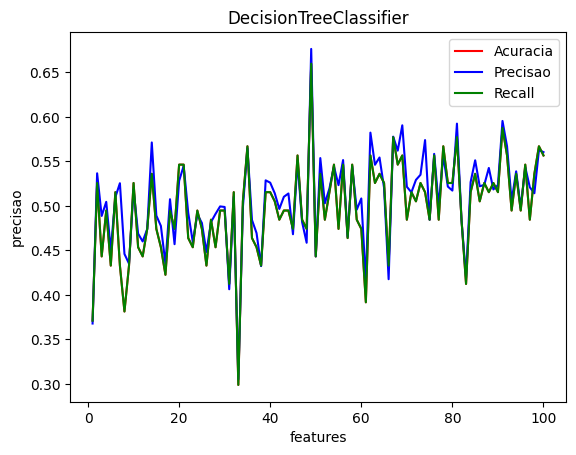

In [95]:
Tree = precisao[precisao.modelo == 'DecisionTreeClassifier'].sort_values(by='features')
plt.plot(Tree.features,Tree.Accuracy, label='Acuracia',color='red')
plt.plot(Tree.features,Tree.Precision, label='Precisao',color = 'blue')
plt.plot(Tree.features,Tree.Accuracy, label='Recall',color='green')
plt.xlabel('features')
plt.ylabel('precisao')
plt.title('DecisionTreeClassifier')
plt.legend()
plt.show()

In [96]:
Tree[Tree.Precision == Tree.Precision.max()]

,Accuracy,Precision,Recall,features,modelo
145,0.659794,0.676358,0.659794,49,DecisionTreeClassifier


In [97]:
Tree[Tree.Accuracy == Tree.Accuracy.max()]

,Accuracy,Precision,Recall,features,modelo
145,0.659794,0.676358,0.659794,49,DecisionTreeClassifier


In [98]:
Tree[Tree.Recall == Tree.Recall.max()]

,Accuracy,Precision,Recall,features,modelo
145,0.659794,0.676358,0.659794,49,DecisionTreeClassifier


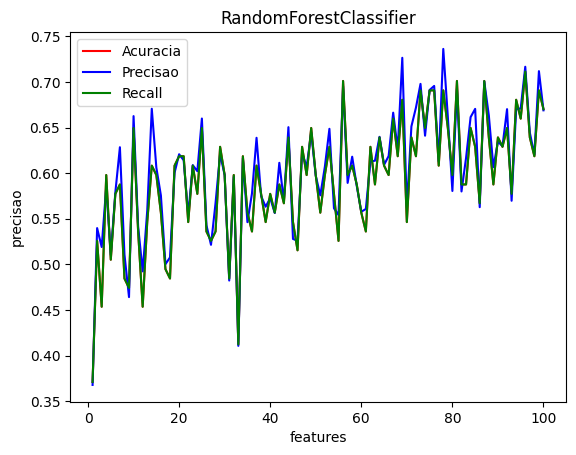

In [99]:
Forest = precisao[precisao.modelo == 'RandomForestClassifier'].sort_values(by='features')
plt.plot(Forest.features,Forest.Accuracy, label='Acuracia',color='red')
plt.plot(Forest.features,Forest.Precision, label='Precisao',color = 'blue')
plt.plot(Forest.features,Forest.Accuracy, label='Recall',color='green')
plt.xlabel('features')
plt.ylabel('precisao')
plt.title('RandomForestClassifier')
plt.legend()
plt.show()

In [100]:
Forest[Forest.Precision == Forest.Precision.max()]

,Accuracy,Precision,Recall,features,modelo
231,0.690722,0.736157,0.690722,78,RandomForestClassifier


In [101]:
Forest[Forest.Accuracy == Forest.Accuracy.max()]

,Accuracy,Precision,Recall,features,modelo
285,0.71134,0.716624,0.71134,96,RandomForestClassifier


In [102]:
Forest[Forest.Recall == Forest.Recall.max()]

,Accuracy,Precision,Recall,features,modelo
285,0.71134,0.716624,0.71134,96,RandomForestClassifier


In [178]:
MelhoresFeatures=96

In [179]:
numeroDeFeatures = MelhoresFeatures
try:
    X = pd.DataFrame(columns=np.arange(numeroDeFeatures+1), dtype='float32').astype(np.float32)
    j = 0
    k = 0
    u = 0
    p = 0
    for i, filename in enumerate(os.listdir('Crying')):
        last_number_frames = -1
        if filename.endswith(".wav"):
            audiofile, sr = librosa.load('Crying/' + filename)
            fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=numeroDeFeatures)
            x = pd.DataFrame(fingerprint, dtype='float32')
            x[numeroDeFeatures] = 'Crying'
            X.loc[i] = x.loc[0]
            j = i
    for i, filename in enumerate(os.listdir('laugh')):
        if filename.endswith(".wav"):
            #print filename
            audiofile, sr = librosa.load('laugh/' + filename)
            fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=numeroDeFeatures)
            x = pd.DataFrame(fingerprint, dtype='float32')
            x[numeroDeFeatures] = 'laugh'
            X.loc[i + j] = x.loc[0]
            k = i

    for i, filename in enumerate(os.listdir('Noise')):
        if filename.endswith(".ogg"):
            print(i,filename)
            audiofile, sr = librosa.load('Noise/' + filename)
            fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=numeroDeFeatures)
            x = pd.DataFrame(fingerprint, dtype='float32')
            x[numeroDeFeatures] = 'Noise'
            X.loc[i + j + k] = x.loc[0]
            u = i

    for i, filename in enumerate(os.listdir('silence')):
        if filename.endswith(".wav"):
            #print filename
            audiofile, sr = librosa.load('silence/' + filename)
            fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=numeroDeFeatures)
            x = pd.DataFrame(fingerprint, dtype='float32')
            x[numeroDeFeatures] = 'silence'
            X.loc[i + j + k + u] = x.loc[0]
    X = X.fillna(0)

    y = X[numeroDeFeatures]
    del X[numeroDeFeatures]
    X = X.astype(np.float32)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    listaModeloPrecisao[features-1] = (
        get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test, n_estimators=100,max_features=numeroDeFeatures),
        get_scores(DecisionTreeClassifier, X_train, X_test, y_train, y_test),
        get_scores(SVC, X_train, X_test, y_train, y_test)
    )
except Exception as e:
    print(e)
    pass

0 1-100032-A.ogg
1 1-110389-A.ogg
2 1-13571-A.ogg
3 1-13572-A.ogg
4 1-21421-A.ogg
5 1-22804-A.ogg
6 1-30226-A.ogg
7 1-30344-A.ogg
8 1-32318-A.ogg
9 1-34094-A.ogg
10 1-34094-B.ogg
11 1-40154-A.ogg
12 1-47819-A.ogg
13 1-47819-B.ogg
14 1-47819-C.ogg
15 1-48298-A.ogg
16 1-54747-A.ogg
17 1-56380-A.ogg
18 1-56380-B.ogg
19 1-56907-A.ogg
20 1-59513-A.ogg
21 1-79113-A.ogg
22 1-85362-A.ogg
23 1-97392-A.ogg
24 2-114280-A.ogg
25 2-114587-A.ogg
26 2-116400-A.ogg
27 2-117271-A.ogg
28 2-128465-A.ogg
29 2-128465-B.ogg
30 2-138465-A.ogg
31 2-144137-A.ogg
32 2-56926-A.ogg
33 2-57191-A.ogg
34 2-59565-A.ogg
35 2-59566-A.ogg
36 2-69131-A.ogg
37 2-69131-B.ogg
38 2-70936-A.ogg
39 2-70938-A.ogg
40 2-70939-A.ogg
41 2-72688-A.ogg
42 2-82274-A.ogg
43 2-82274-B.ogg
44 3-123086-A.ogg
45 3-124795-A.ogg
46 3-124958-A.ogg
47 3-130998-A.ogg
48 3-130998-B.ogg
49 3-145577-A.ogg
50 3-146697-A.ogg
51 3-151255-A.ogg
52 3-151557-A.ogg
53 3-151557-B.ogg
54 3-153057-A.ogg
55 3-155130-A.ogg
56 3-155234-A.ogg
57 3-161010-A.ogg


In [180]:
import pickle

def pickle_model(model, modelname):
    with open('Modelos/' + str(modelname) + '.pkl', 'wb') as f:
        return pickle.dump(model, f)

model = RandomForestClassifier()
model.fit(X,y)
pickle_model(model, "RandomForestClassifier_v2")

In [181]:
# Carrega o modelo salvo em formato .pkl
with open('Modelos/' + 'RandomForestClassifier_v2.pkl', 'rb') as arquivo:
    modelo = pickle.load(arquivo)

In [187]:
# Carrega o arquivo de áudio que será classificado
audio, sr = librosa.load('Crying/Louise_01.m4a_9.wav')

# Extrai as características do arquivo de áudio
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=MelhoresFeatures)
media_mfccs = np.mean(mfccs.T, axis=0)

# Faz a previsão usando o modelo carregado
previsao = modelo.predict([media_mfccs])

# Imprime a previsão na tela
print(previsao)

['Noise']


In [183]:
audio, sr = librosa.load('laugh/laugh_1.m4a_25.wav')

# Extrai as características do arquivo de áudio
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=MelhoresFeatures)
media_mfccs = np.mean(mfccs.T, axis=0)

# Faz a previsão usando o modelo carregado
previsao = modelo.predict([media_mfccs])

# Imprime a previsão na tela
print(previsao)

['Noise']


In [184]:
audio, sr = librosa.load('Noise/1-79113-A.ogg')

# Extrai as características do arquivo de áudio
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=MelhoresFeatures)
media_mfccs = np.mean(mfccs.T, axis=0)

# Faz a previsão usando o modelo carregado
previsao = modelo.predict([media_mfccs])

# Imprime a previsão na tela
print(previsao)

['Noise']


In [185]:
audio, sr = librosa.load('silence/silence.wav_64.wav')

# Extrai as características do arquivo de áudio
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=MelhoresFeatures)
media_mfccs = np.mean(mfccs.T, axis=0)

# Faz a previsão usando o modelo carregado
previsao = modelo.predict([media_mfccs])

# Imprime a previsão na tela
print(previsao)

['Noise']
